In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [87]:
inp0 = pd.read_csv("../datasets/english-to-hindi/hindi_english_parallel.csv")
inp0 = inp0.dropna(subset=['english', 'hindi']).head(10000)

In [88]:
inp0['hindi_in'] = inp0['hindi'].apply(lambda x : f"<start> {x}")
inp0['hindi_out'] = inp0['hindi'].apply(lambda x : f"{x} <end>")

In [89]:
eng_tok = Tokenizer()
eng_tok.fit_on_texts(inp0['english'].to_list())
hin_tok = Tokenizer()
hin_tok.fit_on_texts(inp0['hindi_in'].to_list() + inp0['hindi_out'].to_list())

vocab_en = len(eng_tok.word_index) + 1
vocab_hi = len(hin_tok.word_index) + 1

In [90]:
eng_seq = eng_tok.texts_to_sequences(inp0['english'].to_list())
hin_seq_in = hin_tok.texts_to_sequences(inp0['hindi_in'].to_list())
hin_seq_out = hin_tok.texts_to_sequences(inp0['hindi_out'].to_list())

In [91]:
opt_len_eng = int(np.percentile([len(s) for s in eng_seq], 95))
opt_len_hin_in = int(np.percentile([len(s) for s in hin_seq_in], 95))
opt_len_hin_out = int(np.percentile([len(s) for s in hin_seq_out], 95))

In [92]:
eng_padded = pad_sequences(eng_seq, maxlen=opt_len_eng, padding="post")
hin_in_padded = pad_sequences(hin_seq_in, maxlen=opt_len_hin_in, padding="post")
hin_out_padded = pad_sequences(hin_seq_out, maxlen=opt_len_hin_out, padding="post")

In [93]:
X_train, X_test, Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    eng_padded, hin_in_padded, hin_out_padded, test_size=0.2, random_state=42
)

In [112]:
#encoder model
encoder_input_layer = Input(shape=(opt_len_eng,), name="enc_in")
encoder_embedding_layer = Embedding(vocab_en, 128)
encoder_lstm_layer = LSTM(64, return_state = True)

encoder_lstm, hidden_state, cell_state = encoder_lstm_layer(
    encoder_embedding_layer(encoder_input_layer)
)
enc_states = [hidden_state, cell_state]

In [113]:
#decoder model
decoder_input_layer = Input(shape=(opt_len_hin_in, ), name="dec_in")
decoder_embedding_layer = Embedding(vocab_hi, 128)
decoder_lstm_layer = LSTM(64, return_sequences=True, return_state=True, name="dec_lstm")
decoder_dense_layer = Dense(vocab_hi, activation="softmax")

decoder_lstm, hidden_state, cell_state = decoder_lstm_layer(
    decoder_embedding_layer(decoder_input_layer),
    initial_state = enc_states
)

decoder_outputs = decoder_dense_layer(decoder_lstm)

In [114]:
model = Model([encoder_input_layer, decoder_input_layer], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [115]:
history = model.fit(
    [X_train, Xd_train],
    np.expand_dims(yd_train, -1),
    validation_split=0.2,
    epochs=20,
    verbose=1
)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6021 - loss: 4.5398 - val_accuracy: 0.7114 - val_loss: 1.9716
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6937 - loss: 2.0393 - val_accuracy: 0.7147 - val_loss: 1.8269
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7066 - loss: 1.8528 - val_accuracy: 0.7289 - val_loss: 1.7005
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7189 - loss: 1.7254 - val_accuracy: 0.7426 - val_loss: 1.5843
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7332 - loss: 1.5999 - val_accuracy: 0.7516 - val_loss: 1.4954
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7413 - loss: 1.5123 - val_accuracy: 0.7646 - val_loss: 1.4205
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7556 - loss: 1.4260 - val_accuracy: 0.7766 - val_loss: 1.3525
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7660 - loss: 1.3526 - val_accu

In [117]:
eval_loss, eval_acc = model.evaluate(
    [X_test, Xd_test],
    np.expand_dims(yd_test, -1),
    verbose=0
)
print(f"Evaluation Loss: {eval_loss:.4f}, Accuracy: {eval_acc:.4f}")

Evaluation Loss: 0.9397, Accuracy: 0.8400


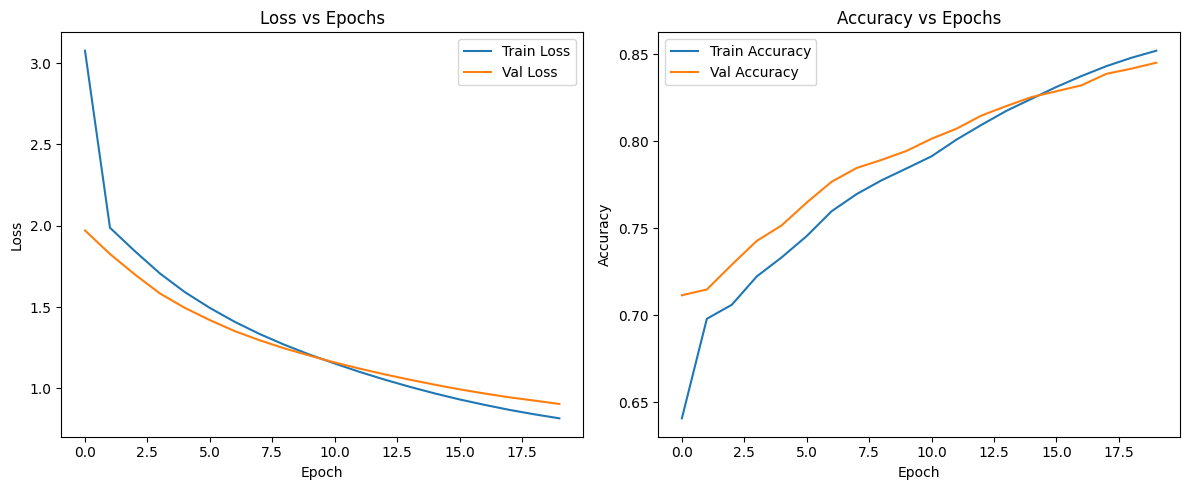

In [118]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()